In [1]:
!pip install kaggle

In [2]:
# Move the uploaded API key to the appropriate folder
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
# Set appropriate permissions for the API key
!chmod 600 ~/.kaggle/kaggle.json
# Download the competition dataset
!kaggle competitions download -c cpe342-karena

100% 921M/922M [00:06<00:00, 149MB/s]
100% 922M/922M [00:06<00:00, 159MB/s]


In [3]:
import zipfile
import os

zip_file_path = "/content/cpe342-karena.zip"
target_folder = "/content/datasets"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

print("Files extracted and appended to", target_folder)

Files extracted and appended to /content/datasets


# Task 5 EDA: Account Security Anomaly Detection

ในส่วนนี้จะสำรวจข้อมูลสำหรับ Task 5 (Account Security Monitoring) อย่างละเอียดก่อนสร้างโมเดล anomaly detection:
- โครงสร้างตารางและ missingness
- การกระจายตัวของฟีเจอร์เชิงตัวเลข (เช่น login/device/location metrics)
- ความสัมพันธ์ระหว่างฟีเจอร์ เพื่อใช้เป็นฐานคิดในการเลือกโมเดลและฟีเจอร์


In [5]:
import pandas as pd

task5_path = "datasets/public_dataset/task5/test.csv"
task5_df = pd.read_csv(task5_path)

print("Task 5 shape:", task5_df.shape)
task5_df.head()


Task 5 shape: (25889, 124)


,id,player_id,login_count_1,login_count_2,login_count_3,login_count_4,login_lat_1,login_lon_1,login_lat_2,login_lon_2,...,guild_changes_1,guild_changes_2,guild_changes_3,guild_changes_4,account_age_days,behavior_stability,password_changed,vpn_usage,suspicious_login_time,mass_item_sale
0,ANS00001,P011753,31.222232,41.790417,28.048736,NaN,-17.074035,127.285635,-17.554811,126.865553,...,1.0,2.0,2.0,1.0,580.020715,0.830282,0.0,1.0,0.0,0.0
1,ANS00002,P010021,61.358999,49.209284,NaN,NaN,48.430879,25.555743,48.708993,26.733951,...,0.0,-1.0,-1.0,1.0,1306.627890,0.700770,0.0,NaN,0.0,0.0
2,ANS00003,P006725,24.763478,37.723228,26.879628,32.503285,8.252684,40.788695,8.346856,40.688039,...,0.0,1.0,-1.0,0.0,835.638378,0.797991,0.0,0.0,0.0,0.0
3,ANS00004,P018170,82.100747,74.862388,73.520927,83.495309,-28.728293,178.990465,-29.104994,178.810800,...,2.0,2.0,1.0,3.0,NaN,0.736845,0.0,NaN,0.0,0.0
4,ANS00005,P003027,50.901216,70.636572,55.606357,68.179388,-46.833704,167.886402,-47.372141,166.767058,...,NaN,-1.0,0.0,0.0,379.053416,0.818901,NaN,0.0,0.0,0.0


## 5.1 โครงสร้างข้อมูล & Missingness

- ตรวจสอบจำนวนแถว/คอลัมน์ของข้อมูล `task5_df`
- ดูตัวอย่างข้อมูล (head) เพื่อทำความเข้าใจประเภทฟีเจอร์
- คำนวณสัดส่วน missing ของแต่ละคอลัมน์ เพื่อใช้วางแผนการเติมค่า (imputation)


In [6]:
import numpy as np

missing_ratio = task5_df.isna().mean().sort_values(ascending=False)
print("Number of columns:", task5_df.shape[1])
print("Number of rows:", task5_df.shape[0])
print("Missing ratio per column:")
missing_ratio.to_frame("missing_ratio").head(20)


Number of columns: 124
Number of rows: 25889
Missing ratio per column:


,missing_ratio
ip_hash_entropy_1,0.052648
kda_mean_1,0.051528
accuracy_mean_2,0.051489
kda_std_2,0.051450
login_lon_1,0.051064
login_count_4,0.050987
activity_level_2,0.050987
play_pattern_consistency_3,0.050871
activity_level_1,0.050794
ip_hash_entropy_2,0.050601


ลงมาทำการ Data Preprocessing, Model Design และส่ง submission

## 5.2 การกระจายตัวของฟีเจอร์เชิงตัวเลข

- แยกคอลัมน์เป็น numeric / categorical
- ดู `describe()` ของ numeric features เพื่อเห็นสเกลและค่าผิดปกติคร่าว ๆ
- วาด histogram/KDE ของบางฟีเจอร์ที่น่าจะเกี่ยวกับความเสี่ยงด้านความปลอดภัย


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = task5_df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = task5_df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns (", len(num_cols), "):", num_cols)
print("Categorical columns (", len(cat_cols), "):", cat_cols)

# summary ของ numeric features
task5_df[num_cols].describe().T


Numeric columns ( 122 ): ['login_count_1', 'login_count_2', 'login_count_3', 'login_count_4', 'login_lat_1', 'login_lon_1', 'login_lat_2', 'login_lon_2', 'login_lat_3', 'login_lon_3', 'login_lat_4', 'login_lon_4', 'location_changes_1', 'location_changes_2', 'location_changes_3', 'location_changes_4', 'device_count_1', 'device_count_2', 'device_count_3', 'device_count_4', 'ip_hash_entropy_1', 'ip_hash_entropy_2', 'ip_hash_entropy_3', 'ip_hash_entropy_4', 'login_time_variance_1', 'login_time_variance_2', 'login_time_variance_3', 'login_time_variance_4', 'session_duration_mean_1', 'session_duration_mean_2', 'session_duration_mean_3', 'session_duration_mean_4', 'session_duration_std_1', 'session_duration_std_2', 'session_duration_std_3', 'session_duration_std_4', 'skill_rating_1', 'skill_rating_2', 'skill_rating_3', 'skill_rating_4', 'skill_trajectory_1', 'skill_trajectory_2', 'skill_trajectory_3', 'skill_trajectory_4', 'play_pattern_consistency_1', 'play_pattern_consistency_2', 'play_patt

,count,mean,std,min,25%,50%,75%,max
login_count_1,24664.0,59.168038,24.382716,8.681218,38.379785,58.207847,78.067660,118.481216
login_count_2,24620.0,59.252681,25.647370,6.771318,38.114418,57.316760,77.630937,128.474795
login_count_3,24661.0,59.141820,24.982790,8.168783,38.168395,57.721300,77.486436,123.552919
login_count_4,24569.0,59.108049,23.822515,7.802166,38.606611,58.437790,78.523744,113.751919
login_lat_1,24619.0,0.011657,34.528865,-61.082098,-29.714988,-0.047400,29.961480,60.927973
...,...,...,...,...,...,...,...,...
behavior_stability,24654.0,0.818170,0.090880,0.201427,0.759536,0.822190,0.885666,0.949999
password_changed,24638.0,0.060557,0.238521,0.000000,0.000000,0.000000,0.000000,1.000000
vpn_usage,24705.0,0.161061,0.367594,0.000000,0.000000,0.000000,0.000000,1.000000
suspicious_login_time,24605.0,0.050315,0.218599,0.000000,0.000000,0.000000,0.000000,1.000000


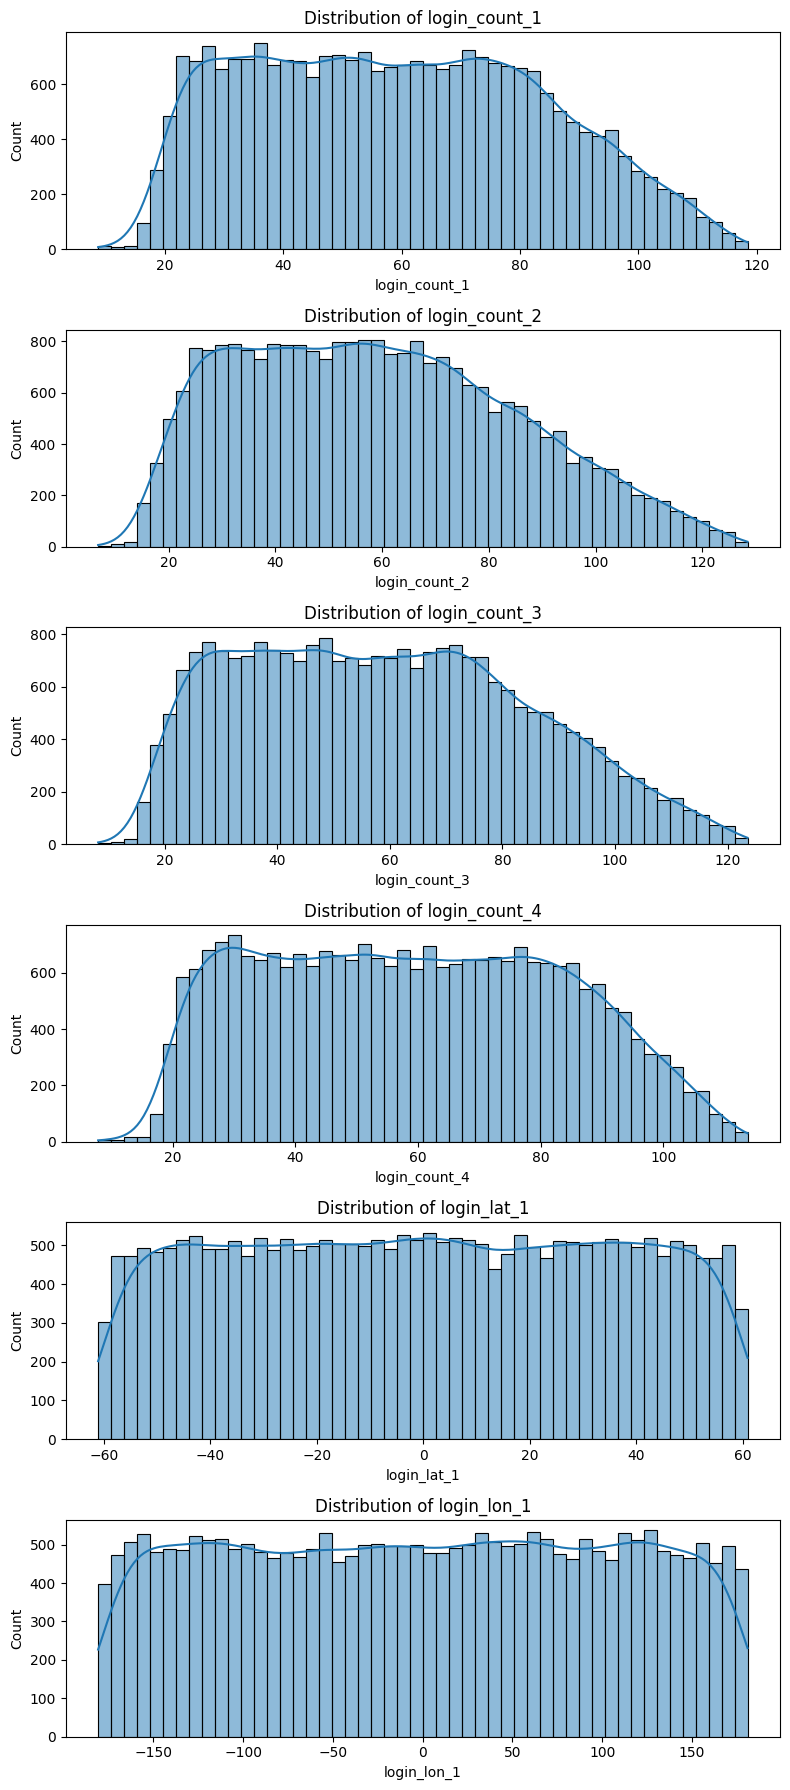

In [8]:
# เลือก numeric features บางตัวมาวาดกราฟ (ปรับ list ให้ตรงกับคอลัมน์จริงหากต้องการเน้นฟีเจอร์เฉพาะด้าน security)
sample_num_cols = num_cols[:6]

fig, axes = plt.subplots(len(sample_num_cols), 1, figsize=(8, 3 * len(sample_num_cols)))
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]

for ax, col in zip(axes, sample_num_cols):
    sns.histplot(task5_df[col], bins=50, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


## 5.3 สรุป Quantile ด้วยกราฟแท่ง

นอกจากดู histogram แล้ว ยังสามารถดูค่าตัดช่วง (quantile) เช่น 25%, 50%, 75% ของฟีเจอร์เชิงตัวเลขบางตัวผ่านกราฟแท่งได้ด้วย
เพื่อเห็นภาพว่าค่ากลาง/ค่าบนของการกระจายตัวอยู่ที่ประมาณเท่าไร.


/tmp/ipython-input-1899276716.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=q.index, y=q.values, palette='viridis')


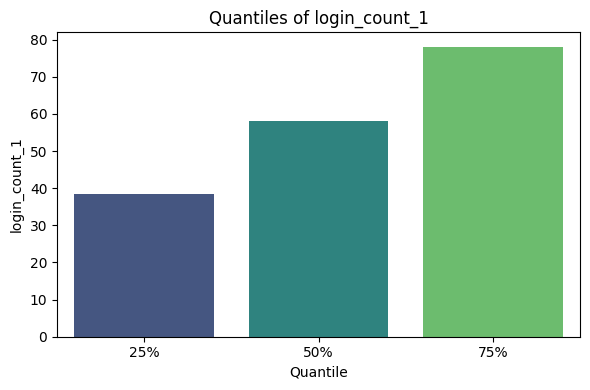

In [9]:
# ตัวอย่าง: แสดง quantile ของฟีเจอร์เชิงตัวเลข 1 ตัวด้วย bar chart
# สามารถเปลี่ยนชื่อคอลัมน์ใน target_col ให้ตรงกับฟีเจอร์ที่สนใจได้
if len(num_cols) > 0:
    target_col = num_cols[0]
    q = task5_df[target_col].quantile([0.25, 0.5, 0.75]).rename(index={0.25: '25%', 0.5: '50%', 0.75: '75%'})

    plt.figure(figsize=(6, 4))
    sns.barplot(x=q.index, y=q.values, palette='viridis')
    plt.title(f'Quantiles of {target_col}')
    plt.xlabel('Quantile')
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.show()
else:
    print('ไม่พบ numeric columns สำหรับทำ quantile bar chart')


## 5.4 ความสัมพันธ์ระหว่างฟีเจอร์ (Correlation overview)

- ดู heatmap ของ correlation ระหว่าง numeric features
- ฟีเจอร์ที่มี correlation สูงมากอาจซ้ำซ้อนกัน ขณะที่ฟีเจอร์ที่สัมพันธ์น้อยอาจเพิ่มมิติใหม่ให้กับโมเดล anomaly detection


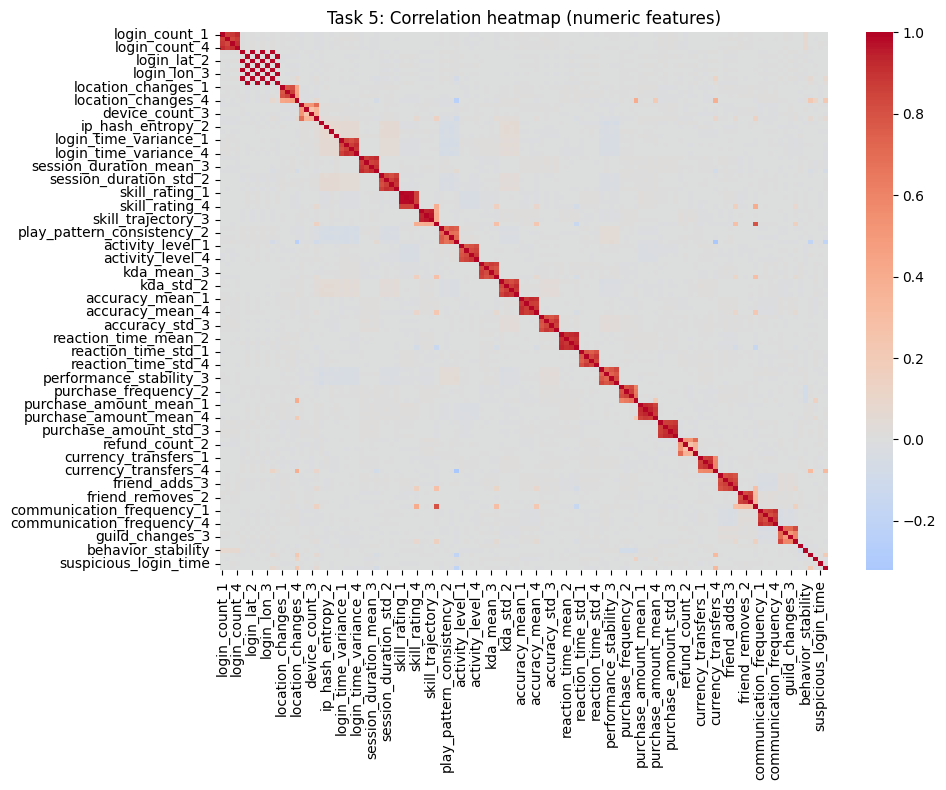

In [10]:
if len(num_cols) > 1:
    corr_mat = task5_df[num_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_mat, cmap="coolwarm", center=0)
    plt.title("Task 5: Correlation heatmap (numeric features)")
    plt.tight_layout()
    plt.show()
else:
    print("มี numeric features ไม่เพียงพอสำหรับทำ correlation heatmap")


ทำการ Data Preprocessing, Model Design และทำ Submission ส่ง

In [ ]:
import pandas as pd
import os
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Search for Task 5 training file
possible_train_paths = [
    "/content/datasets/public_dataset/task5/train.csv",
    "/content/datasets/task5/train.csv",
    "/content/datasets/cpe342-karena/task5/train.csv"
]

train_path = None
for path in possible_train_paths:
    if os.path.exists(path):
        train_path = path
        break

# Also check recursively if not found
if train_path is None:
    for root, dirs, files in os.walk("/content/datasets"):
        if "task5" in root and "train.csv" in files:
            train_path = os.path.join(root, "train.csv")
            break

# Define test path based on train path or default
if train_path:
    test_path = train_path.replace("train.csv", "test.csv")
else:
    # Fallback test path search
    test_path = "/content/datasets/task5/test.csv"
    if not os.path.exists(test_path):
         for root, dirs, files in os.walk("/content/datasets"):
            if "task5" in root and "test.csv" in files:
                test_path = os.path.join(root, "test.csv")
                break

print(f"Train path found: {train_path}")
print(f"Test path found: {test_path}")

if train_path and os.path.exists(train_path):
    print("--- Executing Supervised Learning (XGBoost) ---")
    # Load training data
    df_train = pd.read_csv(train_path)

    # Drop missing targets
    initial_len = len(df_train)
    df_train = df_train.dropna(subset=['is_anomaly'])
    print(f"Dropped {initial_len - len(df_train)} rows with missing target values.")

    X = df_train.drop(columns=['id', 'player_id', 'is_anomaly'])
    y = df_train['is_anomaly']

    # Preprocessing
    numerical_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    numerical_transformer = SimpleImputer(strategy='median')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # XGBoost Classifier
    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)])

    clf.fit(X, y)

    # Predict on Test
    df_test = pd.read_csv(test_path)
    X_test = df_test.drop(columns=['id', 'player_id'])
    predictions = clf.predict(X_test)

else:
    print("--- Executing Unsupervised Learning (Isolation Forest) ---")
    # Load test data
    df_test = pd.read_csv(test_path)
    X_test = df_test.drop(columns=['id', 'player_id'])

    # Preprocessing (scaling is important for distance/density based models)
    numerical_cols = X_test.select_dtypes(include=['number']).columns
    categorical_cols = X_test.select_dtypes(include=['object']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # For Isolation Forest, we ideally need numeric input.
    # We will OneHotEncode categorical, but dimensionality might increase.
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # Fit-transform data
    X_test_processed = preprocessor.fit_transform(X_test)

    # Isolation Forest
    # Contamination: estimated proportion of outliers. 'auto' or small float.
    iso_forest = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)
    iso_forest.fit(X_test_processed)

    # Predict: -1 for outliers, 1 for inliers
    iso_preds = iso_forest.predict(X_test_processed)

    # Map to requirements: -1 -> 1 (Anomaly), 1 -> 0 (Normal)
    predictions = np.where(iso_preds == -1, 1, 0)

# Save predictions
submission_df = pd.DataFrame({'id': df_test['id'], 'task5': predictions})
output_path = '/content/datasets/task5/answer.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
submission_df.to_csv(output_path, index=False)

print(f"Submission saved to {output_path}")
print(submission_df.head())

Train path found: None
Test path found: /content/datasets/public_dataset/task5/test.csv
--- Executing Unsupervised Learning (Isolation Forest) ---
Submission saved to /content/datasets/task5/answer.csv
         id  task5
0  ANS00001      0
1  ANS00002      0
2  ANS00003      0
3  ANS00004      0
4  ANS00005      0
